# Análisis de tweets

Utilizando la API de Twitter se obtuvieron tweets de líderes latinoamericanos que han gobernado o participado en elecciones durante los últimos 20 años. En conjunto de datos con el que se trabaja es el resultado de una limpieza previa. Los campos del conjunto de datos son *screen_name*, *text*, *ranking*, *ranking1* y *word_tk*. Los dos primeros son resultados obtenidos de Twitter, mientras que *ranking* y *ranking1* se han elaborado a partir de la cantidad de me gusta de los tweets por usuario y en general. Finalmente, *word_tk* almacena al campo *text* al cual se ha realizado una limpieza.

## Carga de datos

Se inicia cargando a los datos, para esto se utiliza *read_csv* de turicreate. En turicreate se trabaja con estructuras del tipo *SFrame* entre otras. El cargarlo de está forma nos permite directamente trabajar con este tipo de estructuras.

In [1]:
import turicreate
url = 'https://raw.githubusercontent.com/JairoRB/TextAnalysis/main/datos_rank1.csv'
datos = turicreate.SFrame.read_csv(url)

Downloading https://raw.githubusercontent.com/JairoRB/TextAnalysis/main/datos_rank1.csv to /var/tmp/turicreate-jovyan/441/a5a5a624-a29c-4bf0-b484-8c03678327c5.csv

Finished parsing file https://raw.githubusercontent.com/JairoRB/TextAnalysis/main/datos_rank1.csv

Parsing completed. Parsed 100 lines in 0.35794 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file https://raw.githubusercontent.com/JairoRB/TextAnalysis/main/datos_rank1.csv

Parsing completed. Parsed 36709 lines in 0.267229 secs.

Visualizamos el conjunto de datos.

In [2]:
datos.head(10)

screen_name,text,ranking,ranking1,word_tk
MashiRafael,"“Renacerá mi pueblo de suruina, y pagarán su c ...",5,5,renacerá mi pueblo de suruina y pagarán su c ...
MashiRafael,Viendo a los tiempos aCristina. Con más ene ...,5,5,viendo a los tiempos acristina con más ene ...
MashiRafael,Ya en el aeropuerto deCiudad de México rumbo a ...,5,5,ya en el aeropuerto deciudad de méxico rumbo a ...
MashiRafael,Hoy 1:45 hora de Ecuadorfalleció María Elsa ...,5,5,hoy hora de ecuadorfalleció maría elsa ...
MashiRafael,"🇪🇨🇪🇨🇪🇨\nPor favor,difunde mi mensaje sobre ...",5,5,🇪🇨🇪🇨🇪🇨 por favor difundemi mensaje sobre pandora ...
alferdez,Quiero felicitar a@gabrielboric por haber ...,5,5,quiero felicitar agabrielboric por haber ...
alferdez,Nos vemos mañana ☀️https://t.co/UlGUdc3STv ...,5,5,nos vemos mañana ☀️
alferdez,"El triunfo no es vencer,sino nunca darse por ...",5,5,el triunfo no es vencersino nunca darse por ...
alferdez,Es muy doloroso escucharal expresidente Macri ...,5,5,es muy doloroso escucharal expresidente macri ...
alferdez,Todo mi cariño.\nTe deseouna pronta ...,5,5,todo mi cariño te deseouna pronta recuperación ...


A continuación, el tamaño del conjunto de datos.

In [3]:
datos.shape

(36709, 5)

El conjunto de datos consta de las observaciones de tweets de 20 líderes latinoamericanos, solamente se ha considerado tweets propios, es decir, no se ha tomado en cuenta a retweets realizados con el fin de no repetir tweets. A continuación, un agrupamiento que permite contabilizar la cantidad de tweets por usuario.

In [4]:
datos.groupby('screen_name',operations={'count':turicreate.aggregate.COUNT()}).sort('count',ascending=False).print_rows(20)

+-----------------+-------+
|   screen_name   | count |
+-----------------+-------+
|  LuchoXBolivia  |  3251 |
|  lopezobrador_  |  3251 |
|    DiazCanelB   |  3247 |
|   evoespueblo   |  3162 |
|     dilmabr     |  2898 |
|  ernestosamperp |  2577 |
|   CFKArgentina  |  2417 |
|   LulaOficial   |  2153 |
|   petrogustavo  |  1863 |
|   gabrielboric  |  1822 |
|  chavezcandanga |  1799 |
|  NicolasMaduro  |  1398 |
|     ecuarauz    |  1358 |
| Ollanta_HumalaT |  1102 |
|     lugo_py     |  1009 |
|     alferdez    |  960  |
|   MashiRafael   |  957  |
|     manuelzr    |  700  |
|  XiomaraCastroZ |  453  |
| PedroCastilloTe |  332  |
+-----------------+-------+
[20 rows x 2 columns]



Se observa que los líderes que más tweets propios realizan son Luis Arce, Andrés López Obrador y Miguel Díaz-Canel presidentes de Bolivia, México y Cuba, respectivamente. Además, los líderes que presentan una menor cantidad de tweets propios son los presidentes de Honduras y Perú.

# Conteo de palabras y preparación de datos

Se ajustarán dos modelos de clasificación: *sentiment_model* y *palabras_model*. El primer modelo considera a todas las palabras de *word_tk*, mientras que *palabras_model* considera a las 10 palabras más utilizadas en el conjunto de datos. Se inicia contabilizando la cantidad de palabras por cada tweet de *word_tk*.

In [5]:
palabras = ['pueblo','pais','gobierno','hoy','anios','bolivia','presidente','nacional','gracias','cuba']

In [6]:
datos['word_count'] = turicreate.text_analytics.count_words(datos['word_tk'])

A continuación, se contabiliza la cantidad de palabas más populares por cada tweet de *word_tk*.

In [7]:
def pueblo_count(texto):
    if 'pueblo' in texto:
        valor = texto['pueblo']
    else:
        valor = 0
    return valor

def pais_count(texto):
    if 'país' in texto:
        valor = texto['país']
    else:
        valor = 0
    return valor

def gobierno_count(texto):
    if 'gobierno' in texto:
        valor = texto['gobierno']
    else:
        valor = 0
    return valor

def hoy_count(texto):
    if 'hoy' in texto:
        valor = texto['hoy']
    else:
        valor = 0
    return valor

def anios_count(texto):
    if 'años' in texto:
        valor = texto['años']
    else:
        valor = 0
    return valor

def bolivia_count(texto):
    if 'bolivia' in texto:
        valor = texto['bolivia']
    else:
        valor = 0
    return valor

def presidente_count(texto):
    if 'presidente' in texto:
        valor = texto['presidente']
    else:
        valor = 0
    return valor

def nacional_count(texto):
    if 'nacional' in texto:
        valor = texto['nacional']
    else:
        valor = 0
    return valor

def gracias_count(texto):
    if 'gracias' in texto:
        valor = texto['gracias']
    else:
        valor = 0
    return valor

def cuba_count(texto):
    if 'cuba' in texto:
        valor = texto['cuba']
    else:
        valor = 0
    return valor

In [8]:
datos['pueblo'] = datos['word_count'].apply(pueblo_count)
datos['pais'] = datos['word_count'].apply(pais_count)
datos['gobierno'] = datos['word_count'].apply(gobierno_count)
datos['hoy'] = datos['word_count'].apply(hoy_count)
datos['anios'] = datos['word_count'].apply(anios_count)
datos['bolivia'] = datos['word_count'].apply(bolivia_count)
datos['presidente'] = datos['word_count'].apply(presidente_count)
datos['nacional'] = datos['word_count'].apply(nacional_count)
datos['gracias'] = datos['word_count'].apply(gracias_count)
datos['cuba'] = datos['word_count'].apply(cuba_count)

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 32)"

Note that increasing the degree of parallelism also increases the memory footprint.

Se muestran a los resultados obtenidos con este conteo.

In [9]:
palabras_populares = {'pueblo': datos['pueblo'].sum(),
      'pais': datos['pais'].sum(),
      'gobierno': datos['gobierno'].sum(),
      'hoy': datos['hoy'].sum(),
      'anios': datos['anios'].sum(),
      'bolivia': datos['bolivia'].sum(),
      'presidente': datos['presidente'].sum(),
      'nacional': datos['nacional'].sum(),
      'gracias': datos['gracias'].sum(),
      'cuba': datos['cuba'].sum()
     }
palabras_populares

{'pueblo': 3568.0,
 'pais': 2767.0,
 'gobierno': 2714.0,
 'hoy': 2628.0,
 'anios': 1682.0,
 'bolivia': 1653.0,
 'presidente': 1591.0,
 'nacional': 1455.0,
 'gracias': 1428.0,
 'cuba': 1365.0}

Se contabilizan cantidad de bigramas por cada tweet de *word_tk*.

In [10]:
datos['word_count2'] = turicreate.text_analytics.count_ngrams(datos['word_tk'],2)

Se crea a la variable objetivo, por facilidad se considerará solamente a *ranking1* a partir del cual se crea a *y* con la regla siguiente, si *ranking1* es mayor que 3 se le asigna 1 caso contrario 0.

In [11]:
datos['y'] = datos['ranking1'] >= 4

Observamos al conjunto de datos con los nuevos campos creados.

In [12]:
datos.head(10)

screen_name,text,ranking,ranking1,word_tk
MashiRafael,"“Renacerá mi pueblo de suruina, y pagarán su c ...",5,5,renacerá mi pueblo de suruina y pagarán su c ...
MashiRafael,Viendo a los tiempos aCristina. Con más ene ...,5,5,viendo a los tiempos acristina con más ene ...
MashiRafael,Ya en el aeropuerto deCiudad de México rumbo a ...,5,5,ya en el aeropuerto deciudad de méxico rumbo a ...
MashiRafael,Hoy 1:45 hora de Ecuadorfalleció María Elsa ...,5,5,hoy hora de ecuadorfalleció maría elsa ...
MashiRafael,"🇪🇨🇪🇨🇪🇨\nPor favor,difunde mi mensaje sobre ...",5,5,🇪🇨🇪🇨🇪🇨 por favor difundemi mensaje sobre pandora ...
alferdez,Quiero felicitar a@gabrielboric por haber ...,5,5,quiero felicitar agabrielboric por haber ...
alferdez,Nos vemos mañana ☀️https://t.co/UlGUdc3STv ...,5,5,nos vemos mañana ☀️
alferdez,"El triunfo no es vencer,sino nunca darse por ...",5,5,el triunfo no es vencersino nunca darse por ...
alferdez,Es muy doloroso escucharal expresidente Macri ...,5,5,es muy doloroso escucharal expresidente macri ...
alferdez,Todo mi cariño.\nTe deseouna pronta ...,5,5,todo mi cariño te deseouna pronta recuperación ...


A continuación, la visualización de *y* y de *ranking1*.

In [13]:
datos['y'].show()

Materializing SArray

In [14]:
datos['ranking1'].show()

Materializing SArray

# Conjunto de entrenamiento, validación y prueba

Se crean a los conjuntos de entrenamiento, validación y de prueba.

In [15]:
train_full_data,test_data = datos.random_split(fraction= 0.8, seed=42)

In [16]:
train_data,validation_data = train_full_data.random_split(fraction=0.8, seed=42)

# Modelo con todas las palabras

In [17]:
sentiment_model = turicreate.logistic_classifier.create(train_data,
                                                        target='y', 
                                                        features=['word_count'], 
                                                        validation_set=validation_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 23392

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 47366

Number of coefficients      : 47367

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 1.110279     | 0.807712          | 0.793127            |

| 1         | 6        | 2.500000  | 1.501888     | 0.924419          | 0.826131            |

| 2         | 7        | 2.500000  | 1.702666     | 0.963620          | 0.822729            |

| 3         | 9        | 1.702617  | 1.916879     | 0.974051          | 0.840592            |

| 4         | 10       | 1.702617  | 2.111419     | 0.983456          | 0.839912            |

| 9         | 16       | 1.000000  | 3.204791     | 0.996580          | 0.827833            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

# Modelo con palabras seleccionadas

In [18]:
palabras_model = turicreate.logistic_classifier.create(train_data,
                                                        target='y', 
                                                        features=palabras, 
                                                        validation_set=validation_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 23392

Number of classes           : 2

Number of feature columns   : 10

Number of unpacked features : 10

Number of coefficients      : 11

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.083412     | 0.791681          | 0.787513            |

| 2         | 3        | 0.283335     | 0.791724          | 0.787173            |

| 3         | 4        | 0.490570     | 0.791724          | 0.787173            |

| 4         | 5        | 0.784321     | 0.791724          | 0.787173            |

| 5         | 6        | 0.985978     | 0.791724          | 0.787173            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

## Modelo con bigramas

In [19]:
bigramas_model = turicreate.logistic_classifier.create(train_data,
                                                        target='y', 
                                                        features=['word_count2'], 
                                                        validation_set=validation_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 23392

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 274899

Number of coefficients      : 274900

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.132818     | 0.940920          | 0.812181            |

| 1         | 4        | 1.000000  | 0.436974     | 0.992904          | 0.825111            |

| 2         | 5        | 1.000000  | 0.690569     | 0.994785          | 0.827152            |

| 3         | 6        | 1.000000  | 0.891222     | 0.995853          | 0.828853            |

| 4         | 7        | 1.000000  | 1.100480     | 0.996281          | 0.830044            |

| 9         | 18       | 3.977065  | 2.588039     | 0.996409          | 0.836169            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

# Comparación de modelos

La comparativa de los modelos inicia con la visualización de la curva ROC. En donde se observa el valor de *accuracy*.

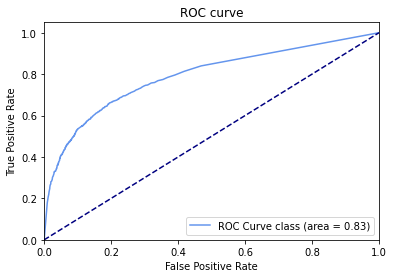

In [20]:
import matplotlib.pyplot as plt

plt.plot(sentiment_model.validation_roc_curve['fpr'],
         sentiment_model.validation_roc_curve['tpr'],
         color ='cornflowerblue',
         label='ROC Curve class (area = %0.2f)' %sentiment_model.validation_accuracy)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

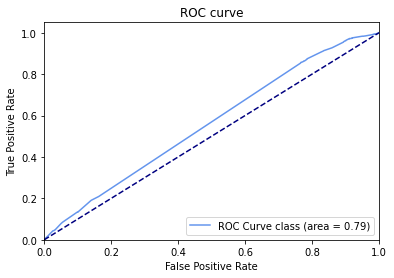

In [21]:
import matplotlib.pyplot as plt

plt.plot(palabras_model.validation_roc_curve['fpr'],
         palabras_model.validation_roc_curve['tpr'],
         color ='cornflowerblue',
         label='ROC Curve class (area = %0.2f)' %palabras_model.validation_accuracy)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

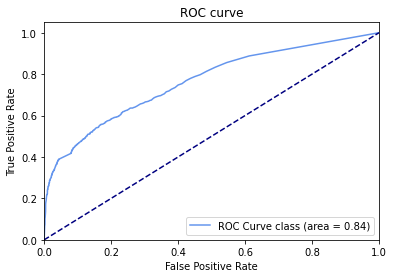

In [22]:
import matplotlib.pyplot as plt

plt.plot(bigramas_model.validation_roc_curve['fpr'],
         bigramas_model.validation_roc_curve['tpr'],
         color ='cornflowerblue',
         label='ROC Curve class (area = %0.2f)' %bigramas_model.validation_accuracy)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

A continuación, se selecciona al primer modelo y se muestra su matriz de confusión. 

In [23]:
sentiment_model.training_confusion_matrix

class,predicted_class,count
0,0,18495
0,1,21
1,0,59
1,1,4817


Se pueden obtener diferentes métricas para el modelo seleccionado. A continuación, algunas de las métricas más utilizadas.

In [24]:
print(f'El valor de la precisión es es {sentiment_model.validation_precision}')
print(f'El valor de la sensibilidad es {sentiment_model.validation_recall}')
print(f'El valor del f1 score es {sentiment_model.validation_f1_score}')

El valor de la precisión es es 0.6226611226611226
El valor de la sensibilidad es 0.47996794871794873
El valor del f1 score es 0.5420814479638009


A continuación, la evaluación del modelo seleccionado sobre el conjunto de prueba.

In [25]:
sentiment_model.evaluate(test_data)

{'accuracy': 0.8234977819599408,
 'auc': 0.7705217013879372,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  722  |
 |      1       |        0        |  827  |
 |      0       |        1        |  486  |
 |      0       |        0        |  5404 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.5237577076532463,
 'log_loss': 0.9105004423009234,
 'precision': 0.597682119205298,
 'recall': 0.46610716591349255,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+---------------------+--------------------+------+------+
 | threshold |         fpr         |        tpr         |  p   |  n   |
 +-----------+---------------------+--------------------+------+------+
 |    0.0 

## Análisis en un usuario en específico

Se seleccionan a los tweets del presidente de México dado que un su mayoría son tweets propios.

In [26]:
tweets = datos[datos['screen_name']== 'lopezobrador_']

Se crean campos con las probabilidades predichas con cada modelo.

In [27]:
tweets['sentiment_model'] = sentiment_model.predict(tweets, output_type = 'probability')

In [28]:
tweets['palabras_model'] = palabras_model.predict(tweets, output_type = 'probability')

In [29]:
tweets['bigramas_model'] = bigramas_model.predict(tweets, output_type = 'probability')

Se ordenan los tweets por valor de probabilidad de mayor a menor considerando el caso del primer modelo.

In [30]:
tweets = tweets.sort('sentiment_model', ascending=False)

Los 10 tweets más populares de acuerdo con el primer modelo.

In [31]:
tweets.head(10)

screen_name,text,ranking,ranking1,word_tk
lopezobrador_,Comimos y platicamos deasuntos de interés con ...,4,5,comimos y platicamos deasuntos de interés con ...
lopezobrador_,"Mis asesores, los rusosde Tuxtla Chico, ...",3,5,mis asesores los rusosde tuxtla chico ...
lopezobrador_,"Agradecí el apoyo,profesionalismo y ...",4,5,agradecí el apoyoprofesionalismo y ...
lopezobrador_,Hoy en La Fraylescareafirmé el compromis ...,4,5,hoy en la fraylescareafirmé el compromis ...
lopezobrador_,"Me informaron BernardoSepúlveda, presidente de ...",3,5,me informaron bernardosepúlveda presidente de ...
lopezobrador_,"Me reuní con ClaudiaMorales, wixárika de ...",5,5,me reuní con claudiamorales wixárika de ...
lopezobrador_,El 20 de noviembre vamosa conmemorar la ...,3,5,el de noviembre vamos aconmemorar la revolución ...
lopezobrador_,En tres días supervisamoslos tramos en ...,3,5,en tres días supervisamoslos tramos en ...
lopezobrador_,Conversamos condirectivos y aficionados ...,3,5,conversamos condirectivos y aficionados ...
lopezobrador_,Tuve el agrado dereunirme con cónsules y ...,3,5,tuve el agrado dereunirme con cónsules y ...


Los 10 tweets menos populares de acuerdo con el primer modelo.

In [32]:
tweets.tail(10)

screen_name,text,ranking,ranking1,word_tk
lopezobrador_,Sostuve un agradableencuentro con el ...,3,5,sostuve un agradableencuentro con el ...
lopezobrador_,Ante la denuncia deMORENA el TRIFE resolvió ...,1,1,ante la denuncia demorena el trife resolvió ...
lopezobrador_,"Pasarán, por laAmericana, Yankees y ...",3,5,pasarán por la americanayankees y houston y por ...
lopezobrador_,"MORENA ganó en el DF,pero el acuerdo Mancera- ...",1,1,morena ganó en el dfpero el acuerdo mancera ...
lopezobrador_,"La maestra Delfina,representante de MORENA ...",1,1,la maestra delfinarepresentante de morena ...
lopezobrador_,"De antología lo dicho porla Sra. Zavala: ""buscaré ...",1,2,de antología lo dicho porla sra zavala buscaré ...
lopezobrador_,Le recomendé queinsistiera en el penacho ...,3,5,le recomendé queinsistiera en el penacho ...
lopezobrador_,Calderón adquirió ellujoso avión de EPN; ...,1,2,calderón adquirió ellujoso avión de epn ...
lopezobrador_,El cartón de hoy de ElFisgón es un compendio ...,5,5,el cartón de hoy de elfisgón es un compendio ...
lopezobrador_,La serie del populismo encontra nuestra será ...,5,5,la serie del populismo encontra nuestra será ...


Se puede profundizar en la selección del mejor modelo, sin embargo, se ha dado prioridad a la creación de modelos y visualización de métricas importantes, junto con  resultados obtenidos.

Elaborado por Jairo Rojas